# CS246 - Colab 6
## node2vec

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!pip install graph2vec-learn

  Created wheel for graph2vec-learn: filename=graph2vec_learn-0.1.3-cp36-none-any.whl size=5709 sha256=b9d8b71cfdb18e59a6d64321f8fd48c6940a9608a304cfb929da1e6a189ca5e7
  Stored in directory: /root/.cache/pip/wheels/0d/96/f7/beab1e19b0a3aad6e7ce16093548b44011a03108c2b9819592
Successfully built graph2vec-learn


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [0]:
import graph2vec
import networkx as nx

class Node2Vec(graph2vec.Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'size': d, 
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example

In the example below, we will try to reproduce the plot in slide 8 of [CS246 - Lecture 12](http://web.stanford.edu/class/cs246/slides/12-graphs2.pdf).

In [4]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2Vec(1, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=1.35
Mapping Walk Names... Done, T=0.04
Training W2V... Done, T=0.43


In [0]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

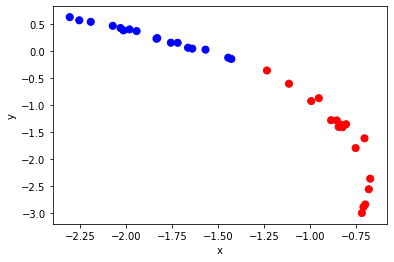

In [6]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

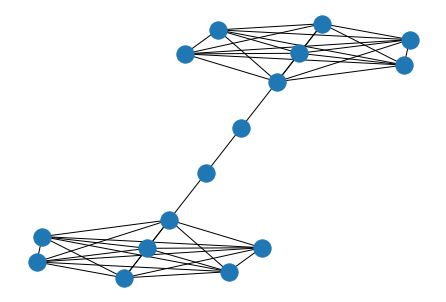

In [7]:
toy_barbell = nx.barbell_graph(7, 2)
nx.draw_kamada_kawai(toy_barbell)



```
# This is formatted as code
```

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [32]:
# YOUR CODE HERE
bar_bell_no_path = nx.barbell_graph(1000, 0)
print(nx.info(bar_bell_no_path))

n2v_bar_bell_no_path = Node2Vec(1, 1, 10)
n2v_bar_bell_no_path.fit(bar_bell_no_path)

Name: 
Type: Graph
Number of nodes: 2000
Number of edges: 999001
Average degree: 999.0010
Making walks... Done, T=0.52
Mapping Walk Names... Done, T=1.53
Training W2V... Done, T=31.66


Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containining the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [44]:
# YOUR CODE HERE
def cos_sim(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def func(G, n2v, n = 0):
  cos_sim_list = []
  vec_n = n2v.predict(n)

  for i in range(len(G)):
    vec_i = n2v.predict(i)
    cos_sim_list.append(cos_sim(vec_n, vec_i))

  return cos_sim_list

def count_neighbors(cos_sim_list):
  count = 0
  for x in cos_sim_list:
    if x > 0.8:
      count += 1

  return count

def exactly_n_neighbors(G, n2v, n = 1000):
  count = 0
  for i in range(len(G)):
    if count_neighbors(func(G, n2v, i)) == n:
      count += 1

  return count

def less_than_n_neighbors(G, n2v, n = 100):
  count = 0
  for i in range(len(G)):
    if count_neighbors(func(G, n2v, i)) < n:
      count += 1

  return count

print(exactly_n_neighbors(bar_bell_no_path, n2v_bar_bell_no_path, n = 1000))

2000


Generate another barbell graph, this time adding a path of length 51 between the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [45]:
# YOUR CODE HERE
bar_bell_with_path = nx.barbell_graph(1000, 50)
print(nx.info(bar_bell_with_path))

n2v_bar_bell_with_path = Node2Vec(1, 1, 10)
n2v_bar_bell_with_path.fit(bar_bell_with_path)

print(exactly_n_neighbors(bar_bell_with_path, n2v_bar_bell_with_path, n = 1000))

Name: 
Type: Graph
Number of nodes: 2050
Number of edges: 999051
Average degree: 974.6839
Making walks... Done, T=0.52
Mapping Walk Names... Done, T=0.85
Training W2V... Done, T=31.87
0


In [46]:
print(less_than_n_neighbors(bar_bell_with_path, n2v_bar_bell_with_path, n = 100))

52


Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!
